In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [16]:
import json
from tqdm.auto import tqdm
from itertools import islice
from datetime import datetime
from collections import Counter
from dataclasses import dataclass
import textwrap

import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertPreTrainedModel, BertConfig, BertTokenizerFast
from morphen.delta_classifier import (
    get_delta_vec,
    feature_extraction_with_key,
    estimate_lda,
    estimate_tree)
output_paths = []

## Data dependencies

```
../data/verb_morpho.csv 15c7c1
../data/10.02-word-split.json 7ac81e
../data/delta_tenc_d200_biwords.bin 04e3f4
```

In [4]:
from hashlib import sha1
from pathlib import Path
paths = ["../data/verb_morpho.csv",          
         "../data/10.02-word-split.json",
         "../data/delta_tenc_d200_biwords.bin"]
for path_x in paths:
    h = sha1()
    h.update(Path(path_x).read_bytes())
    print(path_x, h.hexdigest()[:6])

../data/verb_morpho.csv 15c7c1
../data/10.02-word-split.json 7ac81e
../data/delta_tenc_d200_biwords.bin 04e3f4


## Load dependencies

In [5]:
mr_data = pd.read_csv("../data/verb_morpho.csv", index_col=0)
kv = KeyedVectors.load_word2vec_format("../data/delta_tenc_d200_biwords.bin", binary=True)
with open("../data/10.02-word-split.json", "r", encoding="UTF-8") as fin:
    word_split = json.load(fin)

## Make dataset

In [6]:
mr_data.iloc[:1, ]

,token,token_simp,source,ASBC,Apple (2006-2016),China (2015-2016),Dcard (2019-2020),PTT (2004-2019),MorphoSyntax
4073,丟來,丢来,Corpus,1.0,5.0,5.0,1.0,0.0,VR


In [7]:
## for compatibility with 20.11 and morphen/delta_classifier:feature_extraction
mr_data = mr_data.assign(token_key=mr_data.token)

In [8]:
mr_data.shape

(1676, 10)

## Delta machine

In [9]:
tokenizer = BertTokenizerFast.from_pretrained("D:/LargeFiles/bert-base-chinese")
config = BertConfig.from_pretrained("D:/LargeFiles/bert-base-chinese")

In [13]:
mr_data_train = mr_data.loc[mr_data.token.isin(word_split["train"]),:]
mr_data_test = mr_data.loc[mr_data.token.isin(word_split["test"]),:]

In [14]:
mr_train_entries = mr_data_train.to_dict(orient='records')
mr_test_entries = mr_data_test.to_dict(orient='records')

In [17]:
trainX, trainW, trainY = feature_extraction_with_key("c1+c2", mr_train_entries, kv)
testX, testW, testY = feature_extraction_with_key("c1+c2", mr_test_entries, kv)

In [18]:
trainX.shape, testX.shape

((1240, 400), (304, 400))

In [19]:
# https://github.com/scikit-learn/scikit-learn/blob/36958fb240fbe435673a9e3c52e769f01f36bec0/sklearn/linear_model/_base.py#L408
# scores = safe_sparse_dot(X, self.coef_.T, dense_output=True) + self.intercept_
# return scores.ravel() if scores.shape[1] == 1 else scores
# --
# https://github.com/scikit-learn/scikit-learn/blob/36958fb240fbe435673a9e3c52e769f01f36bec0/sklearn/discriminant_analysis.py#L944
# d = self._decision_function(X)
# y_pred = self.classes_.take(d.argmax(1))

In [20]:
lda = LinearDiscriminantAnalysis()
scaler = MinMaxScaler()
strainX = scaler.fit_transform(trainX)
stestX = scaler.transform(testX)
lda.fit(trainX, trainY)
print(lda.score(testX, testY))
coef = lda.coef_
b = lda.intercept_

0.7138157894736842


In [21]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [22]:
class MrDataset(Dataset):
    def __init__(self, vecs, words, labels):
        assert vecs.shape[0] == len(words) == len(labels)
        self.vecs = vecs
        self.words = words
        self.labels = labels
        
    def __len__(self):
        return len(self.words)
    
    def __getitem__(self, idx):
        return (self.vecs[idx,:], self.words[idx], self.labels[idx])
    

In [39]:
train_ds = MrDataset(trainX, trainW, trainY)
test_ds = MrDataset(testX, testW, testY)

In [40]:
label_map = {x: i for i, x in enumerate(lda.classes_)}
def collate_fn(X):
    vecs = np.vstack([x[0] for x in X])
    vecs = torch.tensor(vecs).float()
    labels = torch.tensor([label_map[x[2]] for x in X]).long()
    words = tokenizer([x[1] for x in X], return_tensors="pt")
    return vecs, words, labels

In [41]:
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16, collate_fn=collate_fn, shuffle=False)

In [42]:
class EpsilonMachine(BertPreTrainedModel):
    def __init__(self, config, lda_coef, lda_b):
        super().__init__(config)        
        self.bert = BertModel(config)
        self.fn1 = nn.Linear(config.hidden_size, 400)
        self.lda_coef = lda_coef
        self.lda_b = lda_b
        
    def forward(self, Xtokens, Xvecs, labels=None):
        h = self.bert(**Xtokens).pooler_output
        eps = self.fn1(h)
        vhat = Xvecs + eps        
        lda_logits = vhat.matmul(self.lda_coef.t()) + self.lda_b        
        if labels is not None:
            loss =  F.cross_entropy(lda_logits, labels)
            return eps, loss
        return eps, None
        

In [43]:
model = EpsilonMachine.from_pretrained('D:/LargeFiles/bert-base-chinese', torch.tensor(coef).float(), torch.tensor(b).float())

Some weights of the model checkpoint at D:/LargeFiles/bert-base-chinese were not used when initializing EpsilonMachine: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing EpsilonMachine from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EpsilonMachine from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EpsilonMachine were not initialized from the model checkpoint at D:/LargeFiles/bert-base-chinese and are newly

In [45]:
loss_vec = []
train_acc = []
test_acc = []
acc_xs = []
optimizer = optim.SGD(model.parameters(), lr=1e-4)

In [50]:
for epoch_i in tqdm(range(10)):    
    for batchX, batchW, batchY in train_loader:    
        optimizer.zero_grad()
        batch_eps, loss = model(batchW, batchX, batchY)
        loss.backward()
        optimizer.step()
        loss_vec.append(loss.item())
        break
    break
    for batchX, batchW, batchY in test_loader:
        
        with torch.no_grad():
            train_eps, _ = model(batchW, batchX)
            test_eps, _ = model(batchW, batchX)        
        train_acc.append(lda.score((batchX+train_eps).numpy(), trainY)) 
        test_acc.append(lda.score((X+test_eps.numpy(), testY)))

  0%|          | 0/10 [00:00<?, ?it/s]

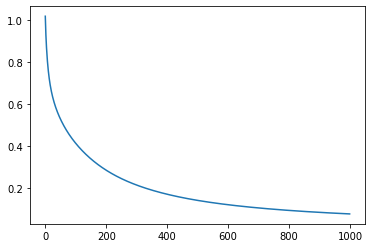

In [30]:
plt.plot(loss_vec)

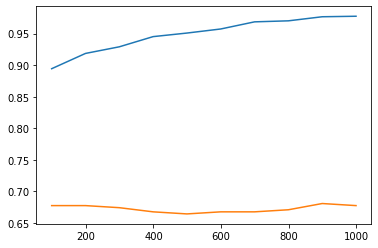

In [34]:
plt.plot(acc_xs, train_acc)
plt.plot(acc_xs, test_acc)

In [33]:
with torch.no_grad():
    train_eps, _ = model(torch.tensor(trainX))
    test_eps, _ = model(torch.tensor(testX))
print("[Train] origin: ", lda.score(trainX, trainY))
print("[Train] origin+eps: ", lda.score(trainX+train_eps.numpy(), trainY))
print("[Test] origin: ", lda.score(testX, testY))
print("[Test] origin+eps: ", lda.score(testX+test_eps.numpy(), testY))

[Train] origin:  0.9330645161290323
[Train] origin+eps:  0.9774193548387097
[Test] origin:  0.7138157894736842
[Test] origin+eps:  0.6776315789473685
